In [93]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor

import skforecast
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster

from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import MaxNLocator


In [95]:
Kenya_ex = pd.read_csv("Kenya2012_2022exportsHS2-6.csv")
Kenya_im = pd.read_csv("Kenya2012_2022importHS2-6.csv")
Africa_east = pd.read_csv("EastAfricadata.csv")


## First Data Inspection
This will cover methods use to inspect what kind of data types and the overall attributes of the dataframe.

In [98]:
Kenya_ex

,HS2,HS2 ID,HS4,HS4 ID,HS6,HS6 ID,Section,Section ID,Trade Value,Year
0,Live animals,101,Horses,10101,Pure-bred Breeding Horses,1010111,Animal Products,1,3846.00,2012
1,Live animals,101,Horses,10101,Non-breeding Horses,1010119,Animal Products,1,13300.00,2012
2,Live animals,101,Horses,10101,"Live Donkeys, Mules, and Crossbreeds",1010120,Animal Products,1,9355.00,2012
3,Live animals,101,Bovine,10102,Pure-bred Breeding Cattle,1010210,Animal Products,1,56766.00,2012
4,Live animals,101,Bovine,10102,Non-breeding Cattle,1010290,Animal Products,1,2624789.00,2012
...,...,...,...,...,...,...,...,...,...,...
40159,Art & antiques,2197,Prints,219702,"Original engravings, prints and lithographs",21970200,Arts and Antiques,21,1849.00,2022
40160,Art & antiques,2197,Sculptures,219703,"Original sculptures and statuary, in any material",21970300,Arts and Antiques,21,638981.00,2022
40161,Art & antiques,2197,Revenue Stamps,219704,"Used postage and revenue stamps, first day cov...",21970400,Arts and Antiques,21,2507.00,2022
40162,Art & antiques,2197,Collector's Items,219705,Collections and collectors pieces,21970500,Arts and Antiques,21,391474.00,2022


In [100]:
Kenya_ex.info()
#The HS stands for Harmonised system code used for exporters and importers to pin point the exact categories, types and anyother specific products

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40164 entries, 0 to 40163
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   HS2          40164 non-null  object 
 1   HS2 ID       40164 non-null  int64  
 2   HS4          40164 non-null  object 
 3   HS4 ID       40164 non-null  int64  
 4   HS6          40164 non-null  object 
 5   HS6 ID       40164 non-null  int64  
 6   Section      40164 non-null  object 
 7   Section ID   40164 non-null  int64  
 8   Trade Value  40164 non-null  float64
 9   Year         40164 non-null  int64  
dtypes: float64(1), int64(5), object(4)
memory usage: 3.1+ MB


In [102]:
Kenya_ex.mean(numeric_only=True)

HS2 ID            1133.21
HS4 ID          113334.84
HS6 ID        11333522.61
Section ID          10.78
Trade Value    1766068.43
Year              2016.98
dtype: float64

In [104]:
Kenya_ex.nunique(axis=0)

HS2               96
HS2 ID            96
HS4             1212
HS4 ID          1212
HS6             4514
HS6 ID          4522
Section           21
Section ID        21
Trade Value    31600
Year              11
dtype: int64

In [106]:
Kenya_ex.describe()

,HS2 ID,HS4 ID,HS6 ID,Section ID,Trade Value,Year
count,40164.00,40164.00,40164.00,40164.00,40164.00,40164.00
mean,1133.21,113334.84,11333522.61,10.78,1766068.43,2016.98
std,562.38,56242.16,5624219.61,5.35,24522157.32,3.14
min,101.00,10101.00,1010111.00,1.00,1.00,2012.00
25%,629.00,62933.00,6293390.00,6.00,3592.75,2014.00
50%,1161.00,116104.00,11610453.00,11.00,29066.50,2017.00
75%,1684.00,168420.00,16842099.00,16.00,198958.25,2020.00
max,2197.00,219706.00,21970600.00,21.00,1390004598.00,2022.00


In [118]:
Kenya_ex.isnull().sum()

HS2                      0
HS2 ID                   0
HS4                      0
HS4 ID                   0
HS6                      0
HS6 ID                   0
Section                  0
Section ID               0
Trade Value              0
Year                     0
Product each industry    0
dtype: int64

In [108]:
Kenya_ex['Product each industry'] = Kenya_ex.groupby('Section')['HS6'].transform('count')


In [110]:
Kenya_ex

,HS2,HS2 ID,HS4,HS4 ID,HS6,HS6 ID,Section,Section ID,Trade Value,Year,Product each industry
0,Live animals,101,Horses,10101,Pure-bred Breeding Horses,1010111,Animal Products,1,3846.00,2012,1425
1,Live animals,101,Horses,10101,Non-breeding Horses,1010119,Animal Products,1,13300.00,2012,1425
2,Live animals,101,Horses,10101,"Live Donkeys, Mules, and Crossbreeds",1010120,Animal Products,1,9355.00,2012,1425
3,Live animals,101,Bovine,10102,Pure-bred Breeding Cattle,1010210,Animal Products,1,56766.00,2012,1425
4,Live animals,101,Bovine,10102,Non-breeding Cattle,1010290,Animal Products,1,2624789.00,2012,1425
...,...,...,...,...,...,...,...,...,...,...,...
40159,Art & antiques,2197,Prints,219702,"Original engravings, prints and lithographs",21970200,Arts and Antiques,21,1849.00,2022,77
40160,Art & antiques,2197,Sculptures,219703,"Original sculptures and statuary, in any material",21970300,Arts and Antiques,21,638981.00,2022,77
40161,Art & antiques,2197,Revenue Stamps,219704,"Used postage and revenue stamps, first day cov...",21970400,Arts and Antiques,21,2507.00,2022,77
40162,Art & antiques,2197,Collector's Items,219705,Collections and collectors pieces,21970500,Arts and Antiques,21,391474.00,2022,77


In [112]:
Kenya_section = Kenya_ex[Kenya_ex['Section'] == "Animal Products"]
Kenya_section.head(20)

,HS2,HS2 ID,HS4,HS4 ID,HS6,HS6 ID,Section,Section ID,Trade Value,Year,Product each industry
0,Live animals,101,Horses,10101,Pure-bred Breeding Horses,1010111,Animal Products,1,3846.00,2012,1425
1,Live animals,101,Horses,10101,Non-breeding Horses,1010119,Animal Products,1,13300.00,2012,1425
2,Live animals,101,Horses,10101,"Live Donkeys, Mules, and Crossbreeds",1010120,Animal Products,1,9355.00,2012,1425
3,Live animals,101,Bovine,10102,Pure-bred Breeding Cattle,1010210,Animal Products,1,56766.00,2012,1425
4,Live animals,101,Bovine,10102,Non-breeding Cattle,1010290,Animal Products,1,2624789.00,2012,1425
5,Live animals,101,Pigs,10103,Pure-bred Breeding Pigs,1010310,Animal Products,1,5893.00,2012,1425
6,Live animals,101,Sheep and Goats,10104,Live Sheep,1010410,Animal Products,1,30951.00,2012,1425
7,Live animals,101,Sheep and Goats,10104,Live Goats,1010420,Animal Products,1,252620.00,2012,1425
8,Live animals,101,Poultry,10105,Domestic Chickens Weighing Under 185 grams,1010511,Animal Products,1,816521.00,2012,1425
9,Live animals,101,Poultry,10105,Other Birds Weighing Under 185 grams (Excludin...,1010519,Animal Products,1,1644.00,2012,1425


In [114]:
Kenya_ex.rename(columns={'Trade Value': 'Trade_Value', 'Section ID': 'Section_ID', 'HS2 ID': 'HS2_ID', 'HS4 ID': 'HS4_ID','HS6 ID': 'HS6_ID' })

,HS2,HS2_ID,HS4,HS4_ID,HS6,HS6_ID,Section,Section_ID,Trade_Value,Year,Product each industry
0,Live animals,101,Horses,10101,Pure-bred Breeding Horses,1010111,Animal Products,1,3846.00,2012,1425
1,Live animals,101,Horses,10101,Non-breeding Horses,1010119,Animal Products,1,13300.00,2012,1425
2,Live animals,101,Horses,10101,"Live Donkeys, Mules, and Crossbreeds",1010120,Animal Products,1,9355.00,2012,1425
3,Live animals,101,Bovine,10102,Pure-bred Breeding Cattle,1010210,Animal Products,1,56766.00,2012,1425
4,Live animals,101,Bovine,10102,Non-breeding Cattle,1010290,Animal Products,1,2624789.00,2012,1425
...,...,...,...,...,...,...,...,...,...,...,...
40159,Art & antiques,2197,Prints,219702,"Original engravings, prints and lithographs",21970200,Arts and Antiques,21,1849.00,2022,77
40160,Art & antiques,2197,Sculptures,219703,"Original sculptures and statuary, in any material",21970300,Arts and Antiques,21,638981.00,2022,77
40161,Art & antiques,2197,Revenue Stamps,219704,"Used postage and revenue stamps, first day cov...",21970400,Arts and Antiques,21,2507.00,2022,77
40162,Art & antiques,2197,Collector's Items,219705,Collections and collectors pieces,21970500,Arts and Antiques,21,391474.00,2022,77


In [116]:
Kenya_ex_2012 = Kenya_ex[Kenya_ex['Year'] == 2012].copy()
Kenya_ex_2012

,HS2,HS2 ID,HS4,HS4 ID,HS6,HS6 ID,Section,Section ID,Trade Value,Year,Product each industry
0,Live animals,101,Horses,10101,Pure-bred Breeding Horses,1010111,Animal Products,1,3846.00,2012,1425
1,Live animals,101,Horses,10101,Non-breeding Horses,1010119,Animal Products,1,13300.00,2012,1425
2,Live animals,101,Horses,10101,"Live Donkeys, Mules, and Crossbreeds",1010120,Animal Products,1,9355.00,2012,1425
3,Live animals,101,Bovine,10102,Pure-bred Breeding Cattle,1010210,Animal Products,1,56766.00,2012,1425
4,Live animals,101,Bovine,10102,Non-breeding Cattle,1010290,Animal Products,1,2624789.00,2012,1425
...,...,...,...,...,...,...,...,...,...,...,...
3545,Art & antiques,2197,Prints,219702,"Original engravings, prints and lithographs",21970200,Arts and Antiques,21,208799.00,2012,77
3546,Art & antiques,2197,Sculptures,219703,"Original sculptures and statuary, in any material",21970300,Arts and Antiques,21,772108.00,2012,77
3547,Art & antiques,2197,Revenue Stamps,219704,"Used postage and revenue stamps, first day cov...",21970400,Arts and Antiques,21,2975.00,2012,77
3548,Art & antiques,2197,Collector's Items,219705,Collections and collectors pieces,21970500,Arts and Antiques,21,38048.00,2012,77


In [36]:
Kenya_ex_2012.nlargest(10, 'Trade Value')

,HS2,HS2 ID,HS4,HS4 ID,HS6,HS6 ID,Section,Section ID,Trade Value,Year,Product each industry
217,"Coffee, tea, mate & spices",209,Tea,20902,"Black Tea (Fermented/Partly, >3kg packages)",2090240,Vegetable Products,2,1.016246e+09,2012,2338
119,"Live trees, plants, bulbs, cut flowers, & orna...",206,Cut Flowers,20603,Fresh cut flowers and flower buds for bouquets,2060310,Vegetable Products,2,6.001379e+08,2012,2338
209,"Coffee, tea, mate & spices",209,Coffee,20901,Unroasted Coffee (Non-Decaffeinated),2090111,Vegetable Products,2,2.639597e+08,2012,2338
578,"Mineral fuels, mineral oils and products of th...",527,Refined Petroleum,52710,"Oils petroleum, bituminous, distillates, excep...",5271000,Mineral Products,5,2.302444e+08,2012,1076
2130,"Precious stones, metals, & pearls",1471,Gold,147108,Gold in unwrought forms non-monetary,14710812,Precious Metals,14,1.889879e+08,2012,303
140,"Edible vegetables, roots, & tubers",207,Legumes,20708,Beans Shelled or Unshelled (Fresh/Chilled),2070820,Vegetable Products,2,1.474748e+08,2012,2338
493,Tobacco & substitutes,424,Rolled Tobacco,42402,Cigarettes containing tobacco,4240220,Foodstuffs,4,8.450817e+07,2012,1679
3249,"Ships, boats, & floating structures",1789,Passenger and Cargo Ships,178901,Cargo vessels other than tanker or refrigerated,17890190,Transportation,17,8.319842e+07,2012,1042
694,Inorganic chemicals,628,Carbonates,62836,Disodium carbonate,6283620,Chemical Products,6,8.119905e+07,2012,5659
907,Pharmaceutical products,630,Packaged Medicaments,63004,"Medicaments nes, in dosage",6300490,Chemical Products,6,6.884685e+07,2012,5659


In [38]:
Kenya_ex_2022 = Kenya_ex[Kenya_ex['Year'] == 2022].copy()
Kenya_ex_2022


,HS2,HS2 ID,HS4,HS4 ID,HS6,HS6 ID,Section,Section ID,Trade Value,Year,Product each industry
36638,Live animals,101,Horses,10101,Pure-bred Breeding Horses,1010111,Animal Products,1,7556.0,2022,1425
36639,Live animals,101,Horses,10101,Non-breeding Horses,1010119,Animal Products,1,3643.0,2022,1425
36640,Live animals,101,Bovine,10102,Pure-bred Breeding Cattle,1010210,Animal Products,1,243891.0,2022,1425
36641,Live animals,101,Bovine,10102,Non-breeding Cattle,1010290,Animal Products,1,443989.0,2022,1425
36642,Live animals,101,Pigs,10103,Pure-bred Breeding Pigs,1010310,Animal Products,1,74587.0,2022,1425
...,...,...,...,...,...,...,...,...,...,...,...
40159,Art & antiques,2197,Prints,219702,"Original engravings, prints and lithographs",21970200,Arts and Antiques,21,1849.0,2022,77
40160,Art & antiques,2197,Sculptures,219703,"Original sculptures and statuary, in any material",21970300,Arts and Antiques,21,638981.0,2022,77
40161,Art & antiques,2197,Revenue Stamps,219704,"Used postage and revenue stamps, first day cov...",21970400,Arts and Antiques,21,2507.0,2022,77
40162,Art & antiques,2197,Collector's Items,219705,Collections and collectors pieces,21970500,Arts and Antiques,21,391474.0,2022,77


In [40]:
Kenya_ex_2022.nlargest(10,'Trade Value') 

,HS2,HS2 ID,HS4,HS4 ID,HS6,HS6 ID,Section,Section ID,Trade Value,Year,Product each industry
36873,"Coffee, tea, mate & spices",209,Tea,20902,"Black Tea (Fermented/Partly, >3kg packages)",2090240,Vegetable Products,2,1.349478e+09,2022,2338
36762,"Live trees, plants, bulbs, cut flowers, & orna...",206,Cut Flowers,20603,Fresh cut flowers and flower buds for bouquets,2060310,Vegetable Products,2,6.577071e+08,2022,2338
36864,"Coffee, tea, mate & spices",209,Coffee,20901,Unroasted Coffee (Non-Decaffeinated),2090111,Vegetable Products,2,3.284433e+08,2022,2338
37222,"Ores, slag and ash",526,Titanium Ore,52614,Titanium ores and concentrates,5261400,Mineral Products,5,2.898481e+08,2022,1076
36833,"Edible fruits, nuts & fruit peels",208,Tropical Fruits,20804,Avocados (Fresh/Dried),2080440,Vegetable Products,2,1.824063e+08,2022,2338
38773,"Precious stones, metals, & pearls",1471,Gold,147108,Gold in unwrought forms non-monetary,14710812,Precious Metals,14,1.598451e+08,2022,303
36987,"Animal or vegetable fats, oils, & waxes",315,Palm Oil,31511,Palm oil or fractions simply refined,3151190,Animal and Vegetable Bi-Products,3,1.463654e+08,2022,463
36828,"Edible fruits, nuts & fruit peels",208,Other Nuts,20802,Other Fresh/Dried Edible Nuts,2080290,Vegetable Products,2,1.056770e+08,2022,2338
37350,Inorganic chemicals,628,Carbonates,62836,Disodium carbonate,6283620,Chemical Products,6,9.880694e+07,2022,5659
37163,Tobacco & substitutes,424,Rolled Tobacco,42402,Cigarettes containing tobacco,4240220,Foodstuffs,4,9.717860e+07,2022,1679


In [42]:
def most_traded(year, section, n):
    return Kenya_ex[(Kenya_ex.Year == year) &  (Kenya_ex.Section == section)].nlargest(n, 'Trade Value')

In [44]:
most_traded(2018, 'Animal Products', 5)

,HS2,HS2 ID,HS4,HS4 ID,HS6,HS6 ID,Section,Section ID,Trade Value,Year,Product each industry
22154,Meat & edible offal,102,Sheep and Goat Meat,10204,Goat Meat,1020450,Animal Products,1,33147783.0,2018,1425
22191,"Fish, crustaceans, & molluscs",103,Non-fillet Frozen Fish,10303,Fish (Other Varieties) (Frozen),1030379,Animal Products,1,23728098.0,2018,1425
22194,"Fish, crustaceans, & molluscs",103,Fish Fillets,10304,Fish Fillets (Frozen),1030420,Animal Products,1,12200615.0,2018,1425
22228,"Edible products of animal origin, n.e.s.",104,Concentrated Milk,10402,Unsweetened Cream Powder (<1.5% Fat),1040221,Animal Products,1,11878264.0,2018,1425
22155,Meat & edible offal,102,Horse Meat,10205,"Meat from Horses/Donkeys/Mules/Hinnies (Fresh,...",1020500,Animal Products,1,8898610.0,2018,1425


In [46]:
most_traded(2022,'Animal Products', 5)

,HS2,HS2 ID,HS4,HS4 ID,HS6,HS6 ID,Section,Section ID,Trade Value,Year,Product each industry
36666,Meat & edible offal,102,Sheep and Goat Meat,10204,Goat Meat,1020450,Animal Products,1,50461216.0,2022,1425
36658,Meat & edible offal,102,Sheep and Goat Meat,10204,Fresh/Chilled Lamb (Whole & Halves),1020410,Animal Products,1,17887312.0,2022,1425
36659,Meat & edible offal,102,Sheep and Goat Meat,10204,Fresh/Chilled Sheep (Whole & Halves),1020421,Animal Products,1,15570623.0,2022,1425
36704,"Fish, crustaceans, & molluscs",103,"Fish: dried, salted, smoked or in brine",10305,Dried Cod (Not Smoked),1030551,Animal Products,1,12346551.0,2022,1425
36648,Live animals,101,Other Animals,10106,Live Animals (Not Farm Types),1010600,Animal Products,1,9120787.0,2022,1425


In [48]:
Kenya_section = Kenya_ex[Kenya_ex.Section == 'Animal Products'].copy()
Kenya_section
#looking at one certain section to find counts

,HS2,HS2 ID,HS4,HS4 ID,HS6,HS6 ID,Section,Section ID,Trade Value,Year,Product each industry
0,Live animals,101,Horses,10101,Pure-bred Breeding Horses,1010111,Animal Products,1,3846.0,2012,1425
1,Live animals,101,Horses,10101,Non-breeding Horses,1010119,Animal Products,1,13300.0,2012,1425
2,Live animals,101,Horses,10101,"Live Donkeys, Mules, and Crossbreeds",1010120,Animal Products,1,9355.0,2012,1425
3,Live animals,101,Bovine,10102,Pure-bred Breeding Cattle,1010210,Animal Products,1,56766.0,2012,1425
4,Live animals,101,Bovine,10102,Non-breeding Cattle,1010290,Animal Products,1,2624789.0,2012,1425
...,...,...,...,...,...,...,...,...,...,...,...
36750,"Animal originated products, n.e.s.",105,Coral and Shells,10508,Coral and Shells,1050800,Animal Products,1,176158.0,2022,1425
36751,"Animal originated products, n.e.s.",105,Pharmaceutical Animal Products,10510,Pharmaceutical Animal Products,1051000,Animal Products,1,269290.0,2022,1425
36752,"Animal originated products, n.e.s.",105,Other Inedible Animal Products,10511,Bovine Semen,1051110,Animal Products,1,245477.0,2022,1425
36753,"Animal originated products, n.e.s.",105,Other Inedible Animal Products,10511,Inedible Fish and Crustaceans,1051191,Animal Products,1,60427.0,2022,1425


## Export Aggregation

In [52]:
agg = Kenya_ex.groupby(["HS2", "Section"]).agg(
    TotalTrade=('Trade Value', 'sum'),  # Rename to TotalTrade for clarity
    UniqueProduct=('HS6', 'count'),
)

# Step 2: Find the year with the highest trade value within each group
idx = Kenya_ex.groupby(["HS2", "Section"])['Trade Value'].idxmax()

# Step 3: Extract the year with the highest trade value
agg['YearWithMaxTrade'] = Kenya_ex.loc[idx, 'Year'].values

In [54]:
Kenya_ex.columns

Index(['HS2', 'HS2 ID', 'HS4', 'HS4 ID', 'HS6', 'HS6 ID', 'Section',
       'Section ID', 'Trade Value', 'Year', 'Product each industry'],
      dtype='object')

In [56]:
agg

,,TotalTrade,UniqueProduct,YearWithMaxTrade
HS2,Section,,,
Aircraft and spacecraft,Transportation,1.459294e+08,121,2014
Aluminum articles,Metals,3.368558e+08,337,2013
"Animal or vegetable fats, oils, & waxes",Animal and Vegetable Bi-Products,1.526059e+09,463,2022
"Animal originated products, n.e.s.",Animal Products,2.915963e+07,116,2015
Art & antiques,Arts and Antiques,1.701884e+07,77,2018
...,...,...,...,...
Weapons,Weapons,6.026495e+06,77,2012
Wood pulp & paper scrap,Paper Goods,1.726830e+07,80,2012
"Wood, wood articles, & charcoal",Wood Products,1.694825e+08,471,2013


In [58]:
#comparing trade value of unique products HS6 between 2012 and 2022
Kenya_exmerge = Kenya_ex_2022[["HS6", "Trade Value"]].merge (Kenya_ex_2012[["HS6","Trade Value"]], how = "inner", on = "HS6", 
                                                             suffixes = ("_2022", "_2012"))
Kenya_exmerge

,HS6,Trade Value_2022,Trade Value_2012
0,Pure-bred Breeding Horses,7556.0,3846.0
1,Non-breeding Horses,3643.0,13300.0
2,Pure-bred Breeding Cattle,243891.0,56766.0
3,Non-breeding Cattle,443989.0,2624789.0
4,Pure-bred Breeding Pigs,74587.0,5893.0
...,...,...,...
3092,"Original engravings, prints and lithographs",1849.0,208799.0
3093,"Original sculptures and statuary, in any material",638981.0,772108.0
3094,"Used postage and revenue stamps, first day cov...",2507.0,2975.0
3095,Collections and collectors pieces,391474.0,38048.0


In [60]:
#before making correlation we will first look at the total trade value
Kenya_extotaltrade = Kenya_ex.groupby(['Year'])['Trade Value'].sum()
pd.options.display.float_format = '{:.2f}'.format
Kenya_extotaltrade.reset_index()

,Year,Trade Value
0,2012,5381065449.00
1,2013,6252921123.00
2,2014,6255924691.00
3,2015,6300150565.00
4,2016,6061765727.00
5,2017,6125540454.00
6,2018,6681927464.00
7,2019,6556288362.00
8,2020,6704909582.00
9,2021,7270116152.00


matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Text(0.5, 1.0, 'Total Trade Value per Year')

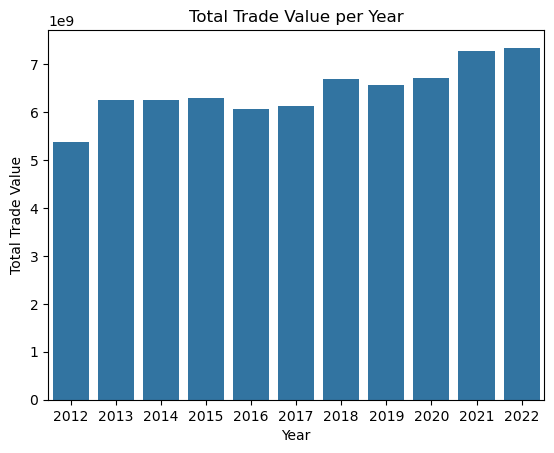

In [62]:
sns.barplot(x=Kenya_extotaltrade.index, y=Kenya_extotaltrade.values)

# Set labels and title
plt.xlabel('Year')
plt.ylabel('Total Trade Value')
plt.title('Total Trade Value per Year')
#compared with the most exported goods which is vegetable products we can see a correlating trend between Total Trade value

In [63]:
# Group by year and section to find the total trade value per section per year
# This will show the Year and Section as the multi-level indices
yearly_exports = Kenya_ex.groupby(['Year', 'Section'])['Trade Value'].sum().reset_index()

# Pivot the data to get a better format for plotting
pivot_exports = yearly_exports.pivot(index='Year', columns='Section', values='Trade Value').fillna(0)

In [65]:
yearly_exports

,Year,Section,Trade Value
0,2012,Animal Hides,116632342.00
1,2012,Animal Products,135418990.00
2,2012,Animal and Vegetable Bi-Products,66038164.00
3,2012,Arts and Antiques,1659069.00
4,2012,Chemical Products,345872493.00
...,...,...,...
226,2022,Textiles,605827075.00
227,2022,Transportation,53571783.00
228,2022,Vegetable Products,3145773148.00
229,2022,Weapons,2127.00


In [68]:
pivot_exports

Section,Animal Hides,Animal Products,Animal and Vegetable Bi-Products,Arts and Antiques,Chemical Products,Foodstuffs,Footwear and Headwear,Instruments,Machines,Metals,...,Miscellaneous,Paper Goods,Plastics and Rubbers,Precious Metals,Stone And Glass,Textiles,Transportation,Vegetable Products,Weapons,Wood Products
Year,,,,,,,,,,,,,,,,,,,,,
2012,116632342.00,135418990.00,66038164.00,1659069.00,345872493.00,447239115.00,27663162.00,15527412.00,203615157.00,202661357.00,...,33910953.00,76292025.00,136594973.00,196967554.00,24945882.00,331517475.00,199439103.00,2412270993.00,1527574.00,9086484.00
2013,112220685.00,124667792.00,125003582.00,1821453.00,480833483.00,570274584.00,60976270.00,28835662.00,217383840.00,337329436.00,...,62826277.00,119802494.00,213538397.00,240704637.00,38346548.00,413784164.00,104121311.00,2417740145.00,1971933.00,41175258.00
2014,141457437.00,134873618.00,75124494.00,1882439.00,488328854.00,433851426.00,35779614.00,22739869.00,171520661.00,247101317.00,...,50806518.00,123108274.00,128582572.00,43025848.00,19064389.00,482539558.00,99389581.00,2578198504.00,777.00,34674383.00
2015,82645361.00,111601846.00,82245616.00,1421631.00,461369577.00,582523916.00,52767745.00,28056349.00,197298739.00,274297532.00,...,66249191.00,127542336.00,180083105.00,31325260.00,23116691.00,470830248.00,106387914.00,2577431750.00,583460.00,11092510.00
2016,73830856.00,101775906.00,112575979.00,1127653.00,410869328.00,514798349.00,45436252.00,20373711.00,250040870.00,261355606.00,...,62945479.00,124187584.00,154403192.00,23222474.00,17062528.00,456785423.00,148584078.00,2616072962.00,129833.00,8218357.00
2017,104629787.00,115390523.00,99775544.00,1589063.00,412506607.00,523228057.00,43368941.00,17708399.00,147832657.00,262883483.00,...,59221420.00,122687409.00,140120205.00,33257811.00,21556487.00,438181916.00,77720265.00,2882388029.00,194153.00,7172886.00
2018,90390572.00,151698807.00,123363162.00,2298086.00,477717341.00,539993544.00,43114233.00,26040724.00,248114707.00,259794215.00,...,55448712.00,153264586.00,128948592.00,90027435.00,28880423.00,525333504.00,98664402.00,2957420941.00,13026.00,17715339.00
2019,41786437.00,137695181.00,143327208.00,1205974.00,454988369.00,518514081.00,51749147.00,24786871.00,248392625.00,278387861.00,...,56417739.00,114872051.00,121647274.00,364599114.00,28965974.00,473223399.00,114034212.00,2625478192.00,26846.00,14605355.00
2020,26702023.00,129464027.00,196689174.00,1060881.00,479694147.00,595000746.00,51326916.00,23657599.00,159271824.00,278106842.00,...,58739158.00,126661664.00,125481971.00,434598276.00,28045724.00,454070290.00,61680460.00,2778766909.00,373201.00,15943067.00


In [70]:
# Create a correlation matrix using pandas

# Exclude non-numeric columns
corr_matrix = pivot_exports.select_dtypes(include=[ 'float64', 'int64'])

# Now compute the correlation matrix
corr_matrix= pivot_exports.corr()
corr_matrix

Section,Animal Hides,Animal Products,Animal and Vegetable Bi-Products,Arts and Antiques,Chemical Products,Foodstuffs,Footwear and Headwear,Instruments,Machines,Metals,...,Miscellaneous,Paper Goods,Plastics and Rubbers,Precious Metals,Stone And Glass,Textiles,Transportation,Vegetable Products,Weapons,Wood Products
Section,,,,,,,,,,,,,,,,,,,,,
Animal Hides,1.00,-0.29,-0.82,0.63,-0.51,-0.67,-0.60,-0.46,-0.10,-0.57,...,-0.55,-0.37,0.18,-0.57,-0.43,-0.51,0.38,-0.59,0.19,0.32
Animal Products,-0.29,1.00,0.64,0.38,0.59,0.02,0.09,0.16,-0.20,0.49,...,0.03,0.34,-0.27,0.33,0.74,0.60,-0.35,0.58,-0.16,0.22
Animal and Vegetable Bi-Products,-0.82,0.64,1.00,-0.28,0.78,0.58,0.62,0.46,-0.18,0.85,...,0.60,0.53,-0.04,0.48,0.76,0.71,-0.59,0.76,-0.12,0.06
Arts and Antiques,0.63,0.38,-0.28,1.00,0.06,-0.30,-0.29,-0.05,0.01,-0.10,...,-0.28,0.21,0.08,-0.39,0.15,0.08,-0.00,0.03,0.07,0.44
Chemical Products,-0.51,0.59,0.78,0.06,1.00,0.52,0.68,0.71,-0.12,0.86,...,0.72,0.75,0.14,0.18,0.65,0.86,-0.72,0.67,-0.15,0.46
Foodstuffs,-0.67,0.02,0.58,-0.30,0.52,1.00,0.86,0.56,0.00,0.62,...,0.77,0.55,0.41,0.33,0.49,0.39,-0.57,0.41,0.12,-0.02
Footwear and Headwear,-0.60,0.09,0.62,-0.29,0.68,0.86,1.00,0.68,0.10,0.82,...,0.87,0.54,0.55,0.33,0.61,0.48,-0.57,0.33,0.15,0.30
Instruments,-0.46,0.16,0.46,-0.05,0.71,0.56,0.68,1.00,0.40,0.64,...,0.61,0.46,0.31,0.11,0.38,0.45,-0.26,0.39,0.28,0.33
Machines,-0.10,-0.20,-0.18,0.01,-0.12,0.00,0.10,0.40,1.00,-0.11,...,-0.01,-0.01,0.07,-0.03,-0.14,-0.10,0.53,-0.18,0.20,-0.03


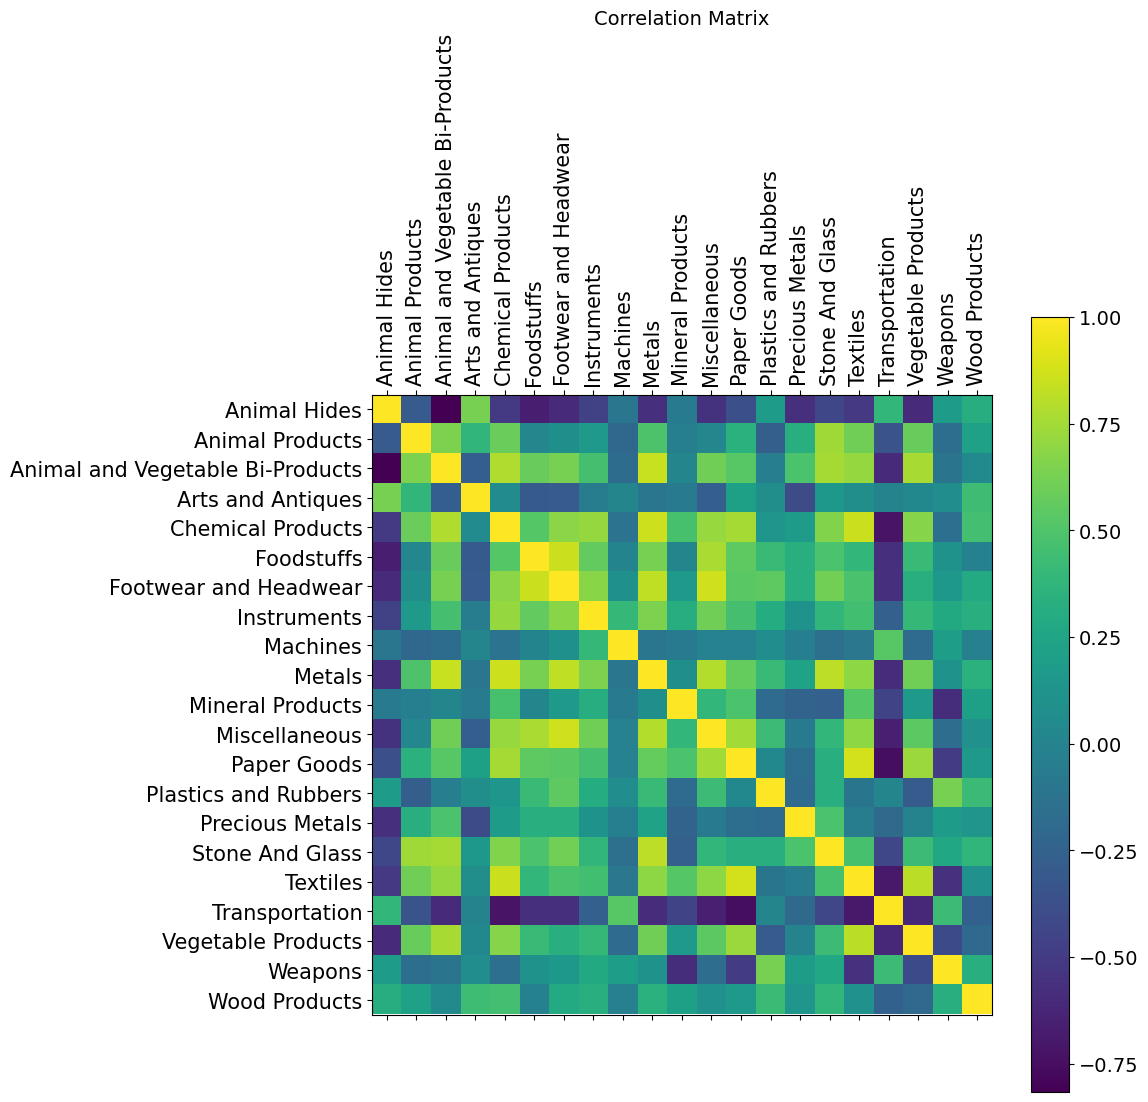

In [72]:

f = plt.figure(figsize=(10, 10)) # figure size 
plt.matshow(pivot_exports.corr(), fignum=f.number) # type of plot
plt.xticks(range(pivot_exports.shape[1]), pivot_exports.columns, fontsize=15, rotation=90) # x axis labels
plt.yticks(range(pivot_exports.shape[1]), pivot_exports.columns, fontsize=15) # y axis labels
cb = plt.colorbar() # add a colour legend (called colorbar)
cb.ax.tick_params(labelsize=14) # add font size
plt.title('Correlation Matrix', fontsize=14) # add title
plt.show() 

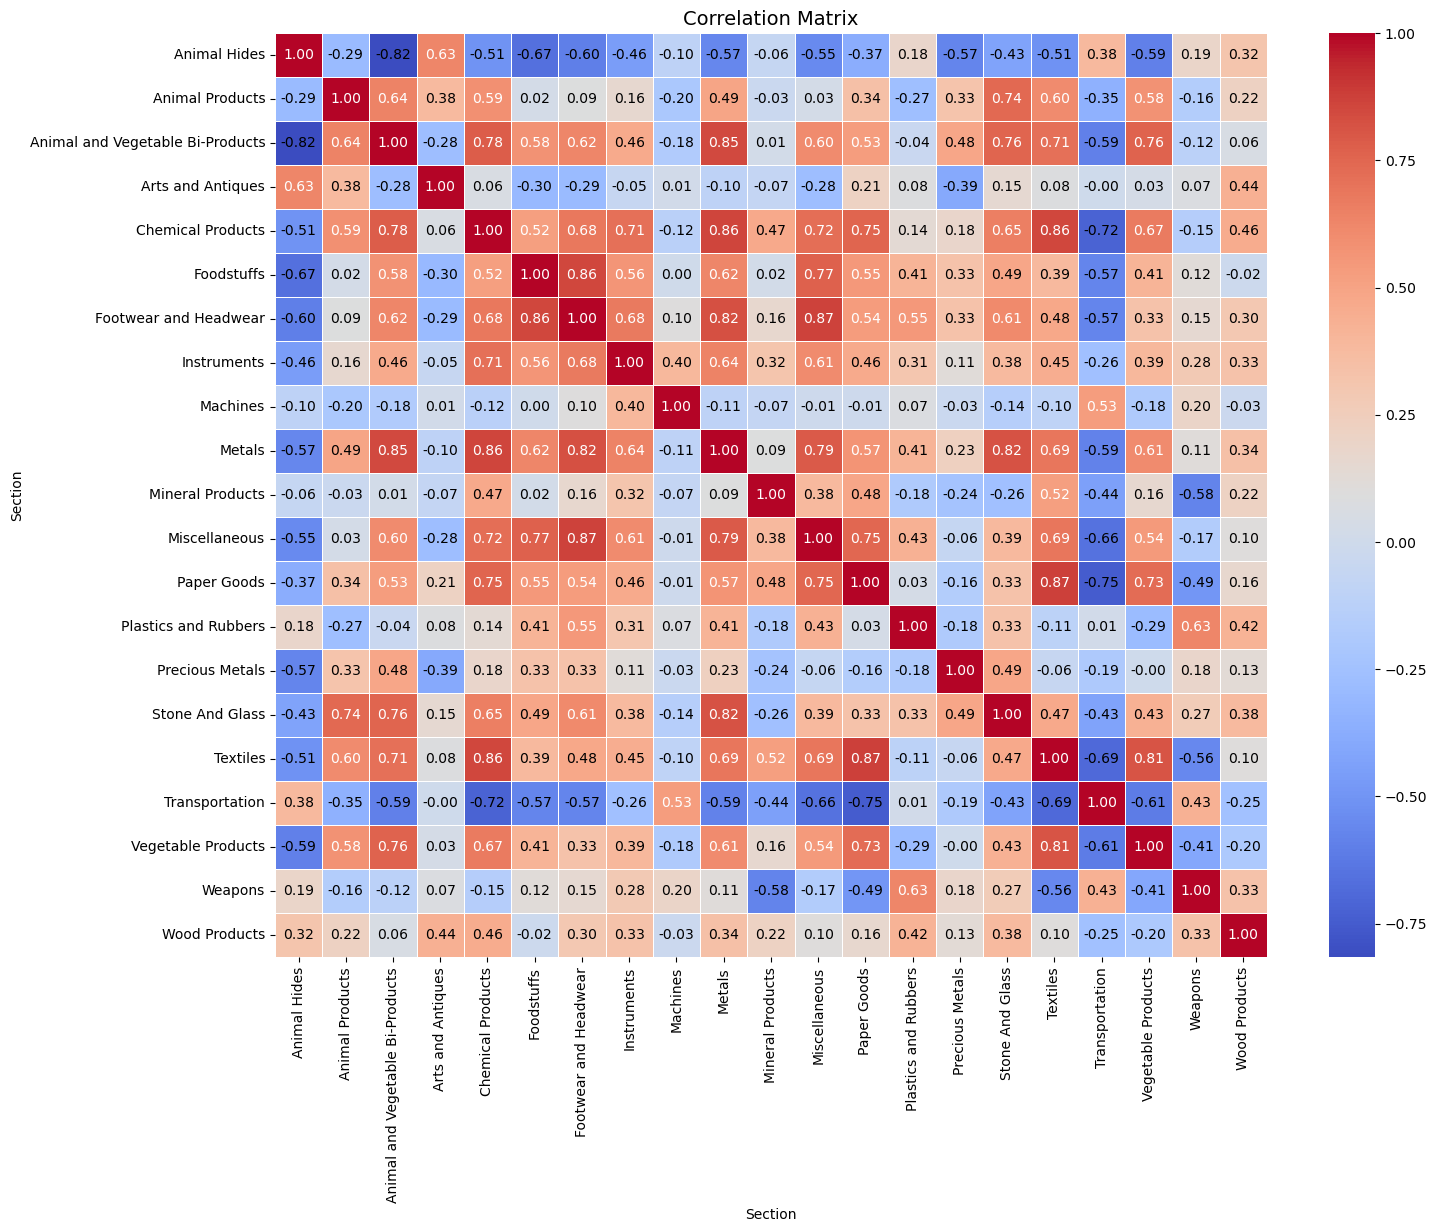

In [73]:
corr_matrix = pivot_exports.corr()
f, ax = plt.subplots(figsize=(16, 12))
# Create the heatmap without annotations
sns.heatmap(corr_matrix, annot=False, ax=ax, cmap='coolwarm', linewidths=0.5)

# Define a threshold to distinguish dark and light cells
threshold = corr_matrix.max().max() / 2  # This is an example threshold

# Manually annotate each cell with the correlation coefficient
for i in range(len(corr_matrix.columns)):
    for j in range(len(corr_matrix.columns)):
        value = corr_matrix.iloc[i, j]
        text_color = "black" if value < threshold else "white"
        ax.text(j + 0.5, i + 0.5, f"{value:.2f}",
                horizontalalignment='center',
                verticalalignment='center',
                color=text_color)



# Now we set the title
plt.title('Correlation Matrix', fontsize=14)

# and finally show the plot
plt.show()

matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


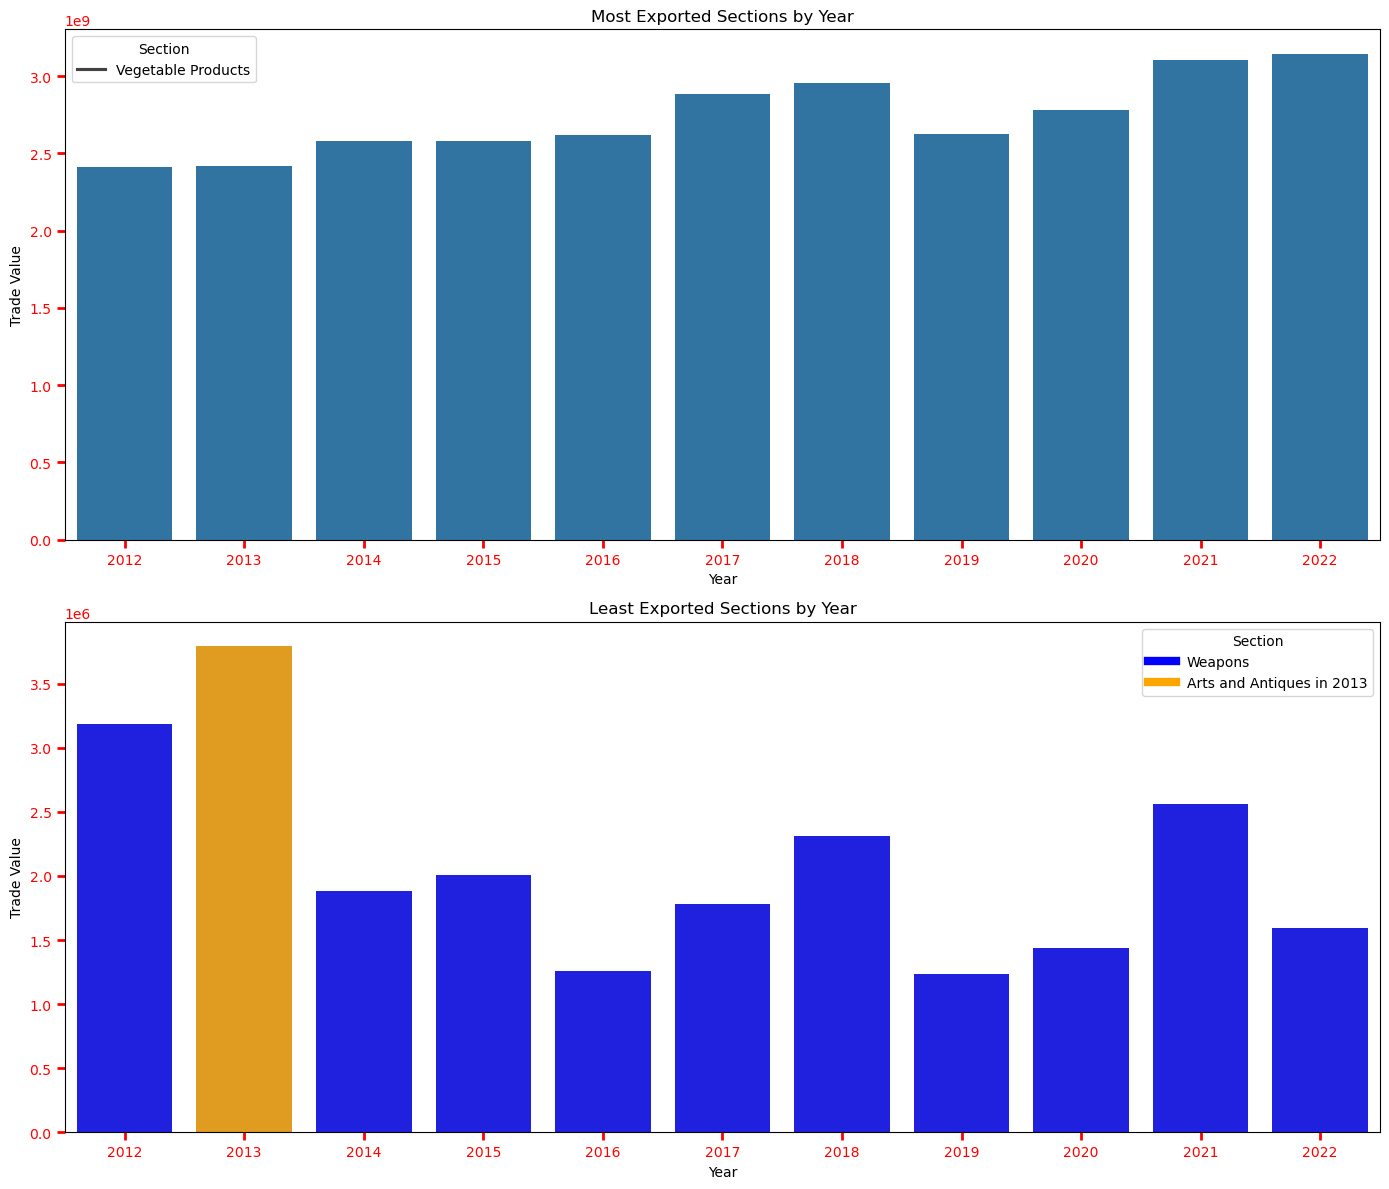

In [74]:

# Get the most and least exported sections
most_exported = pivot_exports.idxmax(axis=1)
least_exported = pivot_exports.idxmin(axis=1)

# Filter the unique labels for both graphs
most_exported_sections = most_exported.unique()
least_exported_sections = least_exported.unique()

# Get the sum of the trade values for each section
most_exported_data = pivot_exports[most_exported_sections].sum(axis=1)
least_exported_data = pivot_exports[least_exported_sections].sum(axis=1)

# Create the bar plot
fig, ax = plt.subplots(2, 1, figsize=(14, 12))

# Plot for most exported sections
sns.barplot(x=most_exported_data.index, y=most_exported_data.values, ax=ax[0])
ax[0].set_title('Most Exported Sections by Year')
ax[0].set_ylabel('Trade Value')
ax[0].set_xlabel('Year')
ax[0].tick_params(axis='both',direction='out', length=6, width=2, colors='r',
               grid_color='r', grid_alpha=0.5)
ax[0].legend(labels=most_exported_sections, title='Section')

# Custom color list for least exported sections
colors = ['blue'] * len(least_exported_data)
year_2013_index = least_exported_data.index.get_loc(2013)  # Find the index for the year 2013
if least_exported[2013] == 'Arts and Antiques':
    colors[year_2013_index] = 'orange'

# Plot for least exported sections with custom colors
sns.barplot(x=least_exported_data.index, y=least_exported_data.values, hue=least_exported_data.index, ax=ax[1], palette=colors)
ax[1].set_title('Least Exported Sections by Year')
ax[1].set_ylabel('Trade Value')
ax[1].set_xlabel('Year')
ax[1].tick_params(axis='both',direction='out', length=6, width=2, colors='r',
               grid_color='r', grid_alpha=0.5)


# Custom legend
legend_handles = [plt.Line2D([0], [0], color='blue', lw=6, label='Weapons'),
                  plt.Line2D([0], [0], color='orange', lw=6, label='Arts and Antiques in 2013')]
ax[1].legend(handles=legend_handles, title='Section')


plt.tight_layout()
plt.show()

In [76]:
least_exported, most_exported
#Checking to see the color for least_exported that has a breakpoint.

(Year
 2012              Weapons
 2013    Arts and Antiques
 2014              Weapons
 2015              Weapons
 2016              Weapons
 2017              Weapons
 2018              Weapons
 2019              Weapons
 2020              Weapons
 2021              Weapons
 2022              Weapons
 dtype: object,
 Year
 2012    Vegetable Products
 2013    Vegetable Products
 2014    Vegetable Products
 2015    Vegetable Products
 2016    Vegetable Products
 2017    Vegetable Products
 2018    Vegetable Products
 2019    Vegetable Products
 2020    Vegetable Products
 2021    Vegetable Products
 2022    Vegetable Products
 dtype: object)

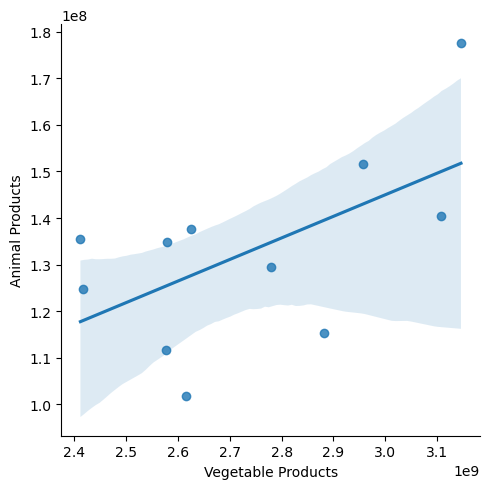

In [77]:
sns.lmplot(x='Vegetable Products', y='Animal Products', data= pivot_exports)

In [ ]:
Kenya_ex['Year'] = pd.to_datetime(Kenya_ex['Year'], format = '%Y'
aggregated_Kenya = Kenya_ex.groupby(["Section", 'HS6'])

## This part is the Imports 

In [80]:
#Next we do the imports for Kenya
Kenya_im_2012 = Kenya_im[Kenya_im.Year == 2012 ].copy()
Kenya_im_2012

,HS2,HS2 ID,HS4,HS4 ID,HS6,HS6 ID,Section,Section ID,Trade Value,Year
0,Live animals,101,Horses,10101,Pure-bred Breeding Horses,1010111,Animal Products,1,185562.00,2012
1,Live animals,101,Horses,10101,Non-breeding Horses,1010119,Animal Products,1,16239.00,2012
2,Live animals,101,Horses,10101,"Live Donkeys, Mules, and Crossbreeds",1010120,Animal Products,1,8204.00,2012
3,Live animals,101,Bovine,10102,Non-breeding Cattle,1010290,Animal Products,1,12187.00,2012
4,Live animals,101,Sheep and Goats,10104,Live Sheep,1010410,Animal Products,1,5.00,2012
...,...,...,...,...,...,...,...,...,...,...
4108,Art & antiques,2197,Paintings,219701,"Collages, similar decorative plaques",21970190,Arts and Antiques,21,280945.00,2012
4109,Art & antiques,2197,Prints,219702,"Original engravings, prints and lithographs",21970200,Arts and Antiques,21,22842.00,2012
4110,Art & antiques,2197,Sculptures,219703,"Original sculptures and statuary, in any material",21970300,Arts and Antiques,21,10716100.00,2012
4111,Art & antiques,2197,Revenue Stamps,219704,"Used postage and revenue stamps, first day cov...",21970400,Arts and Antiques,21,270.00,2012


In [81]:
Kenya_im_2022 = Kenya_im[Kenya_im.Year == 2022 ].copy()
Kenya_im_2022

,HS2,HS2 ID,HS4,HS4 ID,HS6,HS6 ID,Section,Section ID,Trade Value,Year
42132,Live animals,101,Horses,10101,Pure-bred Breeding Horses,1010111,Animal Products,1,402123.00,2022
42133,Live animals,101,Horses,10101,Non-breeding Horses,1010119,Animal Products,1,13145.00,2022
42134,Live animals,101,Bovine,10102,Pure-bred Breeding Cattle,1010210,Animal Products,1,2098061.00,2022
42135,Live animals,101,Bovine,10102,Non-breeding Cattle,1010290,Animal Products,1,2873054.00,2022
42136,Live animals,101,Pigs,10103,Pigs Weighing Over 50 kg (Excluding Breeding P...,1010392,Animal Products,1,2726.00,2022
...,...,...,...,...,...,...,...,...,...,...
46363,Art & antiques,2197,Prints,219702,"Original engravings, prints and lithographs",21970200,Arts and Antiques,21,12479.00,2022
46364,Art & antiques,2197,Sculptures,219703,"Original sculptures and statuary, in any material",21970300,Arts and Antiques,21,68007.00,2022
46365,Art & antiques,2197,Revenue Stamps,219704,"Used postage and revenue stamps, first day cov...",21970400,Arts and Antiques,21,4810.00,2022
46366,Art & antiques,2197,Collector's Items,219705,Collections and collectors pieces,21970500,Arts and Antiques,21,82799.00,2022
